# Алгоритм Форда-Фалкерсона

In [1]:
%matplotlib inline
import networkx as nx
import sys
import math
from collections import defaultdict, deque

In [2]:
# Disable plot axes by default
import matplotlib as mpl
if True:
    mpl.rc('axes.spines', top=False, bottom=False, left=False, right=False)
    mpl.rc('xtick', top=False, bottom=False, labelsize=0)
    mpl.rc('ytick', left=False, right=False, labelsize=0)

In [3]:
from IPython.display import Image, HTML

def pydot_image(graph, prog='dot', width=None):
    dot = nx.nx_pydot.to_pydot(graph)
    if width:
        return Image(dot.create_png(prog=prog), width=width)
    else:
        return HTML(dot.create_svg(prog=prog).decode())

## Prepare tests

In [4]:
test_input = "4 5\n0 1 3\n1 2 1\n0 2 1\n1 3 1\n2 3 3\n"

In [5]:
def to_lines(input_str):
    return (line for line in test_input.splitlines())

def nx_max_flow(input_lines):
    num_verts, num_edges = map(int, next(input_lines).split())
    G = nx.DiGraph()
    for line in input_lines:
        a, b, cap = map(int, line.split())
        G.add_edge(a, b, capacity=cap)
    return nx.maximum_flow_value(G, 0, num_verts-1)

print(nx_max_flow(to_lines(test_input)))

3


In [6]:
from random import shuffle, randint

def random_network(max_nodes, min_nodes=4, max_node_edges=4, max_capacity=20, as_graph=False):
    max_nodes = max(max_nodes, min_nodes)
    while True:
        num = randint(min_nodes, max_nodes)
        deg_in = [randint(1, max_node_edges) for i in range(num)]
        deg_out = deg_in[:]
        shuffle(deg_out)
        graph = nx.directed_configuration_model(in_degree_sequence=deg_in,
                                                out_degree_sequence=deg_out)
        edges = set((a,b) for a,b,c in sorted(graph.edges) if a!=b)
        graph = nx.DiGraph(list(edges))
        nodes = sorted(graph.nodes)
        graph = nx.relabel_nodes(graph, {nodes[i]: i for i in range(len(nodes))})
        start, end = 0, len(nodes)-1
        graph.remove_edges_from(list(graph.in_edges(start)) + list(graph.out_edges(end)))
        if nx.is_weakly_connected(graph):
            break
    for a,b in graph.edges:
        cap = randint(1, max_capacity)
        graph.edges[a,b]['capacity'] = cap
        graph.edges[a,b]['label'] = str(cap)
    if as_graph:
        return graph
    else:
        lines = '%s %s\n' % (len(graph.nodes), len(graph.edges))
        lines += ''.join('%s %s %s\n' % (a, b, graph.edges[a,b]['capacity'])
                         for a,b in sorted(graph.edges))
        return lines

In [7]:
all_tests = [random_network(100) for _ in range(1000)]
big_tests = [random_network(1000) for _ in range(100)]

## Algorithm

In [8]:
import sys
import math
from collections import defaultdict, deque

# поиск максимального потока в сети алгоритмом Форда-Фолкерсона
def ff_max_flow(input_lines):
    num_verts, num_edges = map(int, next(input_lines).split())
    start, end = 0, num_verts-1

    # преобразуем входные данные в массивы связности и массив ограничений
    adjacency, back_edges = defaultdict(set), defaultdict(set)
    capacity, flow = {}, {}
    start = end = 0
    for line in input_lines:
        a, b, cap = map(int, line.split())
        adjacency[a].add(b)
        back_edges[b].add(a)
        end = max(end, a, b)
        capacity[(a,b)] = cap
        flow[(a,b)] = 0

    def find_improveable_path():
        # путь Форда-Фалкерсона ищем поиском в ширину
        queue = deque([start])  # очередь следующего уровня поиска
        visited = set()         # множество уже пройденных вершин
        paths = {}              # здесь собираем найденные рёбра
        while queue:
            a = queue.popleft()
            if a in visited:
                continue
            visited.add(a)
            if a == end:  # нашли путь, если смогли дойти до конечной вершины
                return paths
            for b in adjacency[a]:
                # ищем прямые рёбра, в которые ещё можно добавить поток
                delta = capacity[(a,b)] - flow[(a,b)]
                if delta > 0:
                    if b not in paths:  # учитаываем только 1-й найденный (поиск в ширину)
                        paths[b] = (a, delta, 1)
                    queue.append(b)
            for b in back_edges[a]:
                # ищем обратные рёбра, из которых ещё можно убрать поток
                delta = flow[(b,a)]
                if delta > 0:
                    if a not in paths:  # учитаываем только 1-й найденный (поиск в ширину)
                        paths[a] = (b, delta, -1)
                    queue.append(b)
        return None  # путь не найден

    paths = find_improveable_path()
    while paths:
        # пройдём по пути в первый раз и найдём минимальную коррекцию
        delta_min = math.inf
        b = end
        while b != start:
            a, delta, sign = paths[b]
            delta_min = min(delta_min, delta)
            b = a

        # пройдём по пути во второй раз и скорректируем потоки
        b = end
        while b != start:
            a, delta, sign = paths[b]
            flow[(a,b)] += delta_min * sign
            b = a

        # продолжаем искать путь Форда-Фалкерсона, пока возможно
        paths = find_improveable_path()

    # наилучший поток равен сумме потоков в начале (или в конце)
    max_flow = sum(flow[(a,b)] for a,b in flow.keys() if a==start)
    return max_flow

ff_max_flow(to_lines(test_input))
#print(ff_max_flow(line for line in sys.stdin))

3

## Run tests

In [9]:
# compare execution time with networkx
%timeit nx_max_flow(to_lines(test_input))
%timeit ff_max_flow(to_lines(test_input))

967 µs ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
212 µs ± 22.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
for test in all_tests:
    assert nx_max_flow(to_lines(test)) == ff_max_flow(to_lines(test))
print('all ok')

for test in big_tests:
    assert nx_max_flow(to_lines(test)) == ff_max_flow(to_lines(test))
print('big ok')

all ok
big ok


In [11]:
%timeit [nx_max_flow(to_lines(test)) for test in all_tests]
%timeit [ff_max_flow(to_lines(test)) for test in all_tests]
%timeit [nx_max_flow(to_lines(test)) for test in big_tests]
%timeit [ff_max_flow(to_lines(test)) for test in big_tests]

994 ms ± 102 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
204 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
94.6 ms ± 356 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
20.1 ms ± 999 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Visualize networks

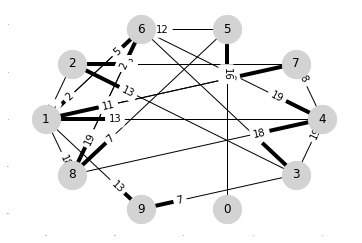

In [12]:
g = random_network(10, as_graph=True)
layout = nx.circular_layout(g)
edge_labels = {(a,b): d['label'] for a,b,d in g.edges.data()}
_ = nx.draw_networkx(g, pos=layout, node_color='lightgray', node_size=800)
_ = nx.draw_networkx_edge_labels(g, pos=layout, edge_labels=edge_labels, label_pos=0.25)

In [13]:
pydot_image(g, 'circo')